In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Stimulus-driven predictive model of brain activity.
What we will need:
- "imagenet_trained_model_weights.pkl"
- The betas and experiment stimuli
- A brain mask

In [2]:
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict, zip_dict
from src.config import *

%matplotlib inline

In [3]:
import torch
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:2") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 4
device#: 0
device name: NVIDIA A100-PCIE-40GB

torch: 1.10.0+cu113
cuda:  11.3
cudnn: 8200
dtype: torch.float32


In [37]:
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime()) # 'Aug-10-2020_1638' #

model_name = 'gnet8r_pred'
model_dir = '%s_%s' % (model_name, timestamp)

output_dir = root_dir+'output/multisubject/%s_%s/' % (model_name, timestamp) 
input_dir = root_dir + 'output/multisubject/gnet8r_mpf_evc_Feb-05-2022_2105/' # 'gnet8r_mpf_evc_Feb-04-2022_1844/'

stim_dir = root_dir+'../../data/nsd/stims/'
voxel_dir = root_dir+'../../data/nsd/voxels/'

exp_design_file = root_dir+"../../data/nsd/nsd_expdesign.mat"


if not os.path.exists(output_dir):
    os.makedirs(output_dir)   

# Load the fake voxel data

In [7]:
## load 
pred_set = h5py.File(input_dir + 'V1_4_pred.h5py', 'r')
checkpoint = embed_dict({k:np.copy(v) for k,v in pred_set.items()})
pred_set.close()
print (checkpoint.keys())

dict_keys(['Bs', 'Rs', 'brain_nii_shape', 'pred', 'val_cc', 'voxel_index', 'voxel_mask', 'voxel_roi'])


In [10]:
voxel_pred = {int(s): v for s,v in checkpoint['pred'].items()}
voxel_roi  = {int(s): v for s,v in checkpoint['voxel_roi'].items()}
voxel_mask = {int(s): v for s,v in checkpoint['voxel_mask'].items()}
voxel_idx  = {int(s): v for s,v in checkpoint['voxel_index'].items()}
val_cc     = {int(s): v for s,v in checkpoint['val_cc'].items()}
Bs = {int(s): v for s,v in checkpoint['Bs'].items()}
Rs = {int(s): v for s,v in checkpoint['Rs'].items()}
subjects = list(voxel_pred.keys()) 

In [12]:
from src.roi import roi_map, iterate_roi

block_group_names = ['V1', 'V2', 'V3', 'hV4']
block_group = [[1,2], [3,4], [5,6], [7]]

# Load the stimuli images
From the subjectwise image preparation

In [13]:
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data = {}
for s in subjects: 
    image_data_set = h5py.File(stim_dir + "S%d_stimuli_227.h5py"%s, 'r')
    image_data[s] = np.copy(image_data_set['stimuli'])
    image_data_set.close()
    print ('--------  subject %d  -------' % s)
    print ('block size:', image_data[s].shape, ', dtype:', image_data[s].dtype, ', value range:',\
           np.min(image_data[s][0]), np.max(image_data[s][0]))

--------  subject 1  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 2  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 3  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 4  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 5  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 6  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 7  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 8  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255


## Examples

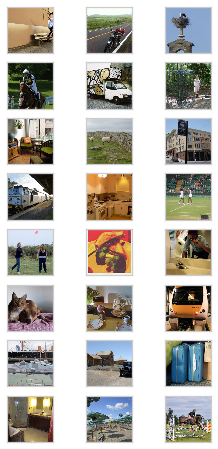

In [16]:
n = 1003
plt.figure(figsize=(4,1*len(subjects)))
for k,s in enumerate(subjects): 
    for i in range(3):
        plt.subplot(len(subjects), 3, 3*k+i+1)
        plt.imshow(image_data[s][n+i].transpose((1,2,0)), cmap='gray', interpolation='None')
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)

# Resample, ordering and split

In [17]:
def ordering_split(voxel, ordering):
    data_size, nv = voxel.shape 
    print ("Total number of voxels = %d" % nv)
    ordering_data = ordering[:data_size]
    shared_mask = ordering_data<1000  # the first 1000 indices are the shared indices

    val_voxel_data = voxel[shared_mask]    
    val_stim_ordering  = ordering_data[shared_mask]
 
    trn_voxel_data = voxel[~shared_mask]
    trn_stim_ordering  = ordering_data[~shared_mask]
    return trn_stim_ordering, trn_voxel_data, val_stim_ordering, val_voxel_data

def zscore(a):
    m = np.mean(a, axis=0, keepdims=True)
    s = np.std(a, axis=0, keepdims=True)
    return (a - m)/s

### No-noise model

In [18]:
noise_model = 'no_noise'
n_repeats = 1

voxel_data = {}
for s in voxel_pred.keys():
    noise    = np.random.normal(0,1,size=(voxel_pred[s].shape[0] * n_repeats, voxel_pred[s].shape[1])).astype(np.float32)
    signal   = np.repeat(zscore(voxel_pred[s]), repeats=n_repeats, axis=0)

    ordering = np.repeat(np.arange(len(voxel_pred[s])), repeats=n_repeats, axis=0)
    voxel_data[s] = signal

### Correlated noise synthetic model

In [15]:
noise_model = 'corr_noise'
n_repeats = 3

voxel_data = {}
for s in voxel_pred.keys():
    noise    = np.random.normal(0,1,size=(voxel_pred[s].shape[0] * n_repeats, voxel_pred[s].shape[1])).astype(np.float32)
    signal   = np.repeat(zscore(voxel_pred[s]), repeats=n_repeats, axis=0)
    
    ordering = np.repeat(np.arange(len(voxel_pred[s])), repeats=n_repeats, axis=0)

    #voxel_data[s] = signal *  B.reshape((1,-1) + noise * np.sqrt(1 -  B.reshape((1,-1)**2)
    voxel_data[s] = signal * B[s].reshape((1,-1)) + np.dot(noise, R[s].T) 

In [17]:
print (voxel_data[subjects[0]].shape)

(10000, 4627)


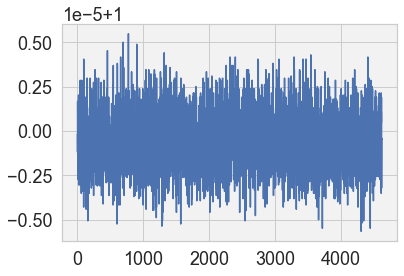

In [18]:
plt.plot(np.var(voxel_data[subjects[0]], axis=0))

---

In [20]:
from src.load_nsd import image_feature_fn, ordering_split
trn_stim_ordering, trn_voxel_data, val_stim_ordering, val_voxel_data = {},{},{},{}

stim_data = {}
data_size, nnv = {}, {}
for k,s in enumerate(subjects):
    print ('--------  subject %d  -------' % s)
    data_size[s], nnv[s] = voxel_data[s].shape      
    stim_data[s] = image_feature_fn(image_data[s])
    
    trn_stim_ordering[s], trn_voxel_data[s], \
    val_stim_ordering[s], val_voxel_data[s] = \
        ordering_split(voxel_data[s], ordering, combine_trial=False)
    
del image_data
del voxel_data

--------  subject 1  -------
Total number of voxels = 4627
--------  subject 2  -------
Total number of voxels = 3765
--------  subject 3  -------
Total number of voxels = 3778
--------  subject 4  -------
Total number of voxels = 3027
--------  subject 5  -------
Total number of voxels = 3685
--------  subject 6  -------
Total number of voxels = 4024
--------  subject 7  -------
Total number of voxels = 3201
--------  subject 8  -------
Total number of voxels = 3490


In [21]:
trn_stim_mean = sum([np.mean(stim_data[s], axis=(0,2,3), keepdims=True) for s in subjects])/len(subjects)
print (trn_stim_mean)

[[[[0.47611815]]

  [[0.45324636]]

  [[0.41308543]]]]


---
# Joint model

In [23]:
from src.torch_joint_training_unpacked_sequences import *
from src.torch_gnet import Encoder
from src.torch_mpf import Torch_LayerwiseFWRF

## Model instanciation

In [24]:
_log_act_fn = lambda _x: T.log(1 + T.abs(_x))*T.tanh(_x)

In [25]:
N = 64

shared_model = Encoder(trn_stim_mean, trunk_width=N).to(device)
rec, fmaps, h = shared_model(T.from_numpy(stim_data[subjects[0]][:20]).to(device))

subject_fwrfs = {s: Torch_LayerwiseFWRF(fmaps, nv=nnv[s], pre_nl=_log_act_fn, \
                 post_nl=_log_act_fn, dtype=np.float32).to(device) for s in subjects}

## Load prefilters value

In [27]:
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url
    
state_dict = load_state_dict_from_url('https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth', progress=True)
        ### Rename dictionary keys to match new breakdown
pre_state_dict = {}
pre_state_dict['conv1.0.weight'] = state_dict.pop('features.0.weight')
pre_state_dict['conv1.0.bias'] = state_dict.pop('features.0.bias')
pre_state_dict['conv2.0.weight'] = state_dict.pop('features.3.weight')
pre_state_dict['conv2.0.bias'] = state_dict.pop('features.3.bias')
  
    
shared_model.pre.load_state_dict(pre_state_dict)
#for s,m in subject_models.items():
#    m.pre.load_state_dict(pre_state_dict)

<All keys matched successfully>

# Loss function, grad function, etc.

In [29]:
optimizer_net = optim.Adam([
        #{'params': shared_model.pre.parameters()},
        {'params': shared_model.enc.parameters()},
    ], lr=1e-3, betas=(0.9, 0.999), eps=1e-08)

subject_optimizer = {s: optim.Adam([
        {'params': sp.parameters()}
    ], lr=1e-3, betas=(0.9, 0.999), eps=1e-08) for s,sp in subject_fwrfs.items()}

#subject_opts = {s: [optimizer_net] for s in subject_optimizer.keys()}
#subject_opts = {s: [subject_optimizer[s]] for s in subject_optimizer.keys()}
subject_opts = {s: [optimizer_net, subject_optimizer[s]] for s in subject_optimizer.keys()}

In [30]:
def _model_fn(_ext, _con, _x):
    '''model consists of an extractor (_ext) and a connection model (_con)'''
    _y, _fm, _h = _ext(_x)
    return _con(_fm)

def _smoothness_loss_fn(_rf, n):
    delta_x = T.sum(T.pow(T.abs(_rf[:, 1:]    - _rf[:, :-1]), n))
    delta_y = T.sum(T.pow(T.abs(_rf[:, :, 1:] - _rf[:, :, :-1]), n))
    return delta_x + delta_y

def vox_loss_fn(r, v, nu=0.5, delta=1.):
    #err = T.sum(huber(r, v, delta), dim=0)
    err = T.sum((r - v)**2, dim=0)
    # squared correlation coefficient with 'leak'
    cr = r - T.mean(r, dim=0, keepdim=True)
    cv = v - T.mean(v, dim=0, keepdim=True)
    wgt = T.clamp(T.pow(T.mean(cr*cv, dim=0), 2) / ((T.mean(cr**2, dim=0)) * (T.mean(cv**2, dim=0)) + 1e-6), min=nu, max=1).detach()
 
    weighted_err = wgt * err # error per voxel
    loss = T.sum(weighted_err) / T.mean(wgt)
    return err, loss
    
def _loss_fn(_ext, _con, _x, _v):
    _r = _model_fn(_ext, _con, _x)
    #_err = T.sum((_r - _v)**2, dim=0)
    #_loss = T.sum(_err)
    _err, _loss = vox_loss_fn(_r, _v, nu=0.1, delta=.5)

    _loss += fpX(1e-1) * T.sum(T.abs(_con.w))
    return _err, _loss
    
    
def _training_fn(_ext, _con, _opts, xb, yb):
    for _opt in _opts:
        _opt.zero_grad()
        _err, _loss = _loss_fn(_ext, _con, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))
        _loss.backward()
        _opt.step()
    return _err

def _holdout_fn(_ext, _con, xb, yb):
    # print (xb.shape, yb.shape)
    _err,_ = _loss_fn(_ext, _con, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))
    return _err

def _pred_fn(_ext, _con, xb):
    return _model_fn(_ext, _con, T.from_numpy(xb).to(device))

# Training
IDEA: Use the more stable estimate from the holdout val cc to weight the voxels
Use a contiguity cost instead of sparsity for RF weights

In [31]:
batch_size = 100
num_epochs = 50
holdout_frac = .1

best_params, final_params, hold_cc_hist, hold_hist, trn_hist, best_epoch, best_joint_cc_score = \
    learn_params_(_training_fn, _holdout_fn, _pred_fn, shared_model, subject_fwrfs, subject_opts, 
        stim_data, trn_voxel_data, trn_stim_ordering,
        num_epochs=num_epochs, batch_size=batch_size, holdout_frac=holdout_frac, masks=None, randomize=False)

subject 1 masked 4627 of 4627
subject 1 training/holdout 8100 900
subject 2 masked 3765 of 3765
subject 2 training/holdout 8100 900
subject 3 masked 3778 of 3778
subject 3 training/holdout 8100 900
subject 4 masked 3027 of 3027
subject 4 training/holdout 8100 900
subject 5 masked 3685 of 3685
subject 5 training/holdout 8100 900
subject 6 masked 4024 of 4024
subject 6 training/holdout 8100 900
subject 7 masked 3201 of 3201
subject 7 training/holdout 8100 900
subject 8 masked 3490 of 3490
subject 8 training/holdout 8100 900
\ : 100.0 %
  Epoch 1 of 50 took       73.992s
  training loss:               0.655085
  holdout loss (batch):        0.519092
  Subject 1: median (max) validation accuracy = 0.564 (0.925)
  Subject 2: median (max) validation accuracy = 0.599 (0.917)
  Subject 3: median (max) validation accuracy = 0.706 (0.950)
  Subject 4: median (max) validation accuracy = 0.730 (0.937)
  Subject 5: median (max) validation accuracy = 0.810 (0.957)
  Subject 6: median (max) validatio

  Subject 4: median (max) validation accuracy = 0.957 (0.988)
  Subject 5: median (max) validation accuracy = 0.964 (0.989)
  Subject 6: median (max) validation accuracy = 0.952 (0.988)
  Subject 7: median (max) validation accuracy = 0.954 (0.984)
  Subject 8: median (max) validation accuracy = 0.961 (0.986)
** Saving params with joint score = 0.951 **

\ : 100.0 %
  Epoch 13 of 50 took       74.778s
  training loss:               0.151613
  holdout loss (batch):        0.106966
  Subject 1: median (max) validation accuracy = 0.937 (0.984)
  Subject 2: median (max) validation accuracy = 0.940 (0.988)
  Subject 3: median (max) validation accuracy = 0.960 (0.987)
  Subject 4: median (max) validation accuracy = 0.962 (0.989)
  Subject 5: median (max) validation accuracy = 0.966 (0.990)
  Subject 6: median (max) validation accuracy = 0.956 (0.989)
  Subject 7: median (max) validation accuracy = 0.959 (0.986)
  Subject 8: median (max) validation accuracy = 0.964 (0.987)
** Saving params wit

  Subject 7: median (max) validation accuracy = 0.981 (0.992)
  Subject 8: median (max) validation accuracy = 0.982 (0.992)
** Saving params with joint score = 0.980 **

\ : 100.0 %
  Epoch 25 of 50 took       74.915s
  training loss:               0.085319
  holdout loss (batch):        0.054452
  Subject 1: median (max) validation accuracy = 0.977 (0.992)
  Subject 2: median (max) validation accuracy = 0.977 (0.992)
  Subject 3: median (max) validation accuracy = 0.983 (0.993)
  Subject 4: median (max) validation accuracy = 0.983 (0.993)
  Subject 5: median (max) validation accuracy = 0.981 (0.994)
  Subject 6: median (max) validation accuracy = 0.981 (0.994)
  Subject 7: median (max) validation accuracy = 0.982 (0.993)
  Subject 8: median (max) validation accuracy = 0.983 (0.992)
** Saving params with joint score = 0.981 **

\ : 100.0 %
  Epoch 26 of 50 took       74.718s
  training loss:               0.083635
  holdout loss (batch):        0.057095
  Subject 1: median (max) valida

  Subject 1: median (max) validation accuracy = 0.983 (0.994)
  Subject 2: median (max) validation accuracy = 0.982 (0.994)
  Subject 3: median (max) validation accuracy = 0.987 (0.995)
  Subject 4: median (max) validation accuracy = 0.986 (0.995)
  Subject 5: median (max) validation accuracy = 0.984 (0.994)
  Subject 6: median (max) validation accuracy = 0.984 (0.995)
  Subject 7: median (max) validation accuracy = 0.986 (0.994)
  Subject 8: median (max) validation accuracy = 0.986 (0.994)
** Saving params with joint score = 0.984 **

\ : 100.0 %
  Epoch 38 of 50 took       74.742s
  training loss:               0.071249
  holdout loss (batch):        0.043986
  Subject 1: median (max) validation accuracy = 0.983 (0.994)
  Subject 2: median (max) validation accuracy = 0.982 (0.994)
  Subject 3: median (max) validation accuracy = 0.987 (0.995)
  Subject 4: median (max) validation accuracy = 0.986 (0.995)
  Subject 5: median (max) validation accuracy = 0.985 (0.995)
  Subject 6: median 

  Subject 7: median (max) validation accuracy = 0.987 (0.995)
  Subject 8: median (max) validation accuracy = 0.987 (0.994)

\ : 100.0 %
  Epoch 50 of 50 took       74.759s
  training loss:               0.066681
  holdout loss (batch):        0.040155
  Subject 1: median (max) validation accuracy = 0.985 (0.995)
  Subject 2: median (max) validation accuracy = 0.984 (0.994)
  Subject 3: median (max) validation accuracy = 0.988 (0.995)
  Subject 4: median (max) validation accuracy = 0.987 (0.995)
  Subject 5: median (max) validation accuracy = 0.986 (0.995)
  Subject 6: median (max) validation accuracy = 0.986 (0.995)
  Subject 7: median (max) validation accuracy = 0.987 (0.995)
  Subject 8: median (max) validation accuracy = 0.987 (0.994)
** Saving params with joint score = 0.986 **



## Results

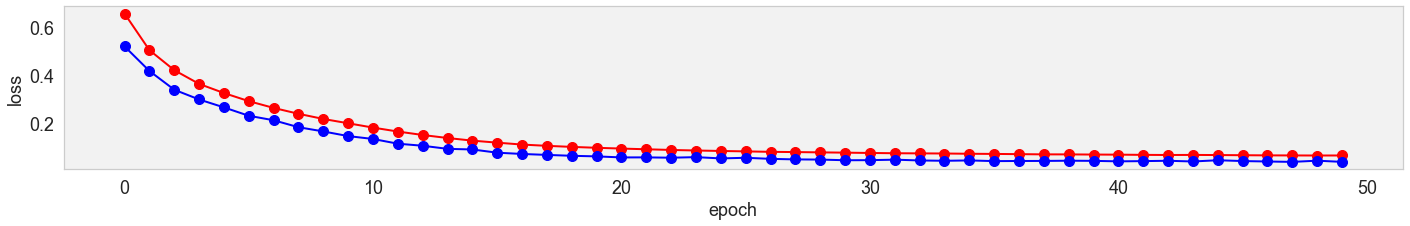

In [32]:
plt.figure(figsize=(24,3))
plt.plot(trn_hist, color='r', marker='o', ms=10, lw=2)
plt.plot(np.array(hold_hist), color='b', marker='o', ms=10, lw=2)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()

No handles with labels found to put in legend.


Text(0.5, 0, 'epoch')

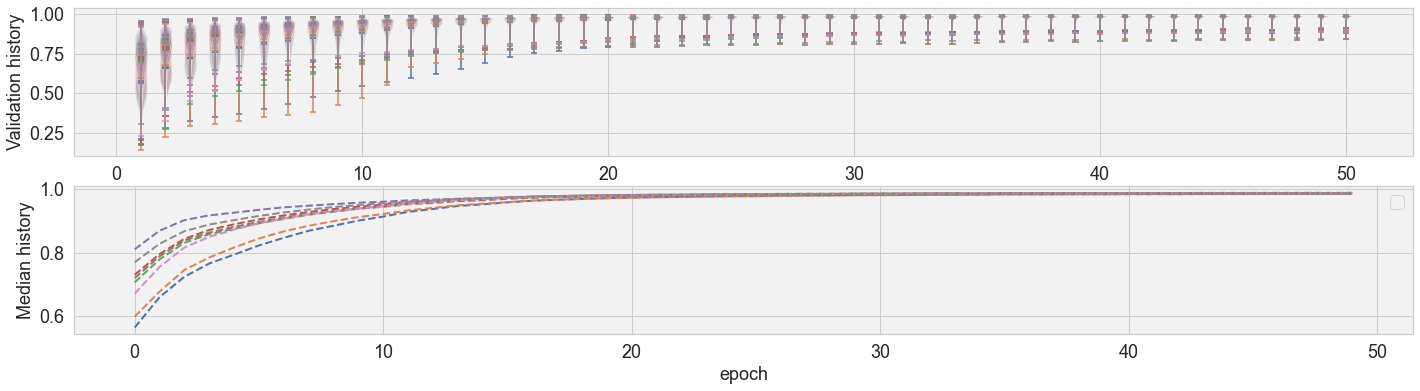

In [33]:
plt.figure(figsize=(24,6))
plt.subplot(2,1,1)
for s,cc in hold_cc_hist.items():
    plt.gca().violinplot(np.nan_to_num(np.array(cc)).T, showmeans=True, showmedians=True, showextrema=True)
plt.ylabel('Validation history')
plt.subplot(2,1,2)
for s in hold_cc_hist.keys():
    p=plt.plot([np.median(cc) for cc in hold_cc_hist[s]], lw=2, linestyle='--')
plt.legend()
plt.ylabel('Median history')
plt.xlabel('epoch')

---
## Final validation accuracy

In [34]:
val_voxel = {s: val_voxel_data[s] for s in val_voxel_data.keys()}
shared_model.load_state_dict(best_params['enc'])
shared_model.eval() 
for s,sd in subject_fwrfs.items():
    sd.load_state_dict(best_params['fwrfs'][s])
    sd.eval() 

batch_size = 50
subject_val_cc = validation_(_pred_fn, shared_model, subject_fwrfs, stim_data, val_voxel, val_stim_ordering, batch_size)
joined_val_cc = np.concatenate(list(subject_val_cc.values()), axis=0)

best joint score = 0.986
best joint val cc = 0.987
subject 1: val cc = 0.986
subject 2: val cc = 0.985
subject 3: val cc = 0.989
subject 4: val cc = 0.988
subject 5: val cc = 0.987
subject 6: val cc = 0.987
subject 7: val cc = 0.987
subject 8: val cc = 0.988


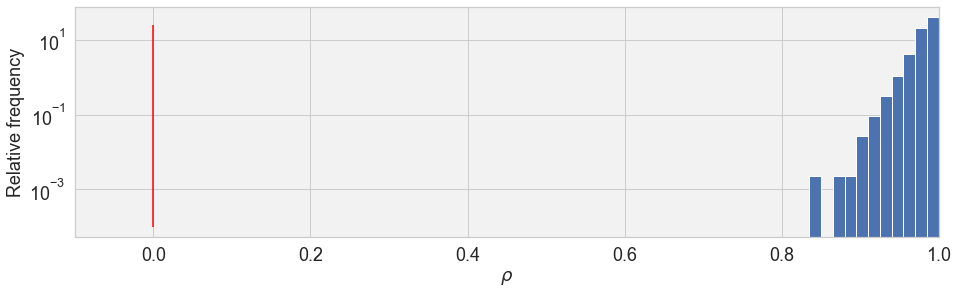

In [35]:
print ("best joint score = %.3f"%best_joint_cc_score)
print ("best joint val cc = %.3f"% np.median(joined_val_cc))
for s,v in subject_val_cc.items():
    print ("subject %s: val cc = %.3f"%(s, np.median(v)))

fig=plt.figure(figsize=(12,4))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
_=plt.hist(joined_val_cc, bins=100, density=True, range=(-.5, 1.))
_=plt.vlines(x=[0], ymin=1e-4, ymax=25, color='r')
_=plt.yscale('log')
_=plt.xlim([-.1, 1.])
_=plt.xlabel(r'$\rho$')
_=plt.ylabel('Relative frequency')

# Save final parameters

In [38]:
torch.save({
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'holdout_frac': holdout_frac,   
            'best_params': best_params, 
            'final_params': final_params,
            'trn_loss_history': trn_hist,
            'hold_loss_history': hold_hist,
            'hold_cc_history': hold_cc_hist,
            'best_epoch': best_epoch,
            'best_joint_cc_score': best_joint_cc_score,
            'val_cc': subject_val_cc,
            'input_mean': trn_stim_mean,
            'voxel_roi': voxel_roi,
            'voxel_mask': voxel_mask,
            'voxel_index': voxel_idx
            }, output_dir+'model_params_%s'%noise_model)

---
# ROI-wise models

In [39]:
block_voxel_masks = {}
for roi_name in block_group_names:
    block_voxel_masks[roi_name] = {}

for s in subjects:
    for roi_mask, roi_name in iterate_roi(block_group, voxel_roi[s], roi_map, group_name=block_group_names):    
        block_voxel_masks[roi_name][s] = roi_mask

print (['%s: %d'%(s,np.sum(v)) for s,v in flatten_dict(block_voxel_masks).items()])

['V1.1: 1348', 'V1.2: 1097', 'V1.3: 1251', 'V1.4: 871', 'V1.5: 1115', 'V1.6: 1130', 'V1.7: 1148', 'V1.8: 1081', 'V2.1: 1415', 'V2.2: 1083', 'V2.3: 1160', 'V2.4: 883', 'V2.5: 1088', 'V2.6: 1191', 'V2.7: 958', 'V2.8: 1040', 'V3.1: 1188', 'V3.2: 1081', 'V3.3: 945', 'V3.4: 800', 'V3.5: 934', 'V3.6: 1215', 'V3.7: 721', 'V3.8: 879', 'hV4.1: 676', 'hV4.2: 504', 'hV4.3: 422', 'hV4.4: 473', 'hV4.5: 548', 'hV4.6: 488', 'hV4.7: 374', 'hV4.8: 490']


In [42]:
batch_size = 100
num_epochs = 50
holdout_frac = .1


#subject_image_pred = {s: np.zeros(shape=(len(image_data[s]), len(r)), dtype=np.float32) for s,r in voxel_roi.items()}
for roi_name, roi_masks in block_voxel_masks.items(): 
    
    roi_nv = {s: np.sum(roi_mask) for s, roi_mask in roi_masks.items()}
    
    print ('***************************************')
    print ('***        %12s       ***'%roi_name)
    print ({s: np.sum(m) for s,m in roi_masks.items()})
    print ('***************************************') 
    
    # create model
    shared_model = Encoder(trn_stim_mean, trunk_width=N).to(device)
    rec, fmaps, h = shared_model(T.from_numpy(stim_data[subjects[0]][:20]).to(device))

    subject_fwrfs = {s: Torch_LayerwiseFWRF(fmaps, nv=roi_nv[s], pre_nl=_log_act_fn, \
                     post_nl=_log_act_fn, dtype=np.float32).to(device) for s in subjects}    
    
    ##################################
    try:
        from torch.hub import load_state_dict_from_url
    except ImportError:
        from torch.utils.model_zoo import load_url as load_state_dict_from_url

    state_dict = load_state_dict_from_url('https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth', progress=True)
            ### Rename dictionary keys to match new breakdown
    pre_state_dict = {}
    pre_state_dict['conv1.0.weight'] = state_dict.pop('features.0.weight')
    pre_state_dict['conv1.0.bias'] = state_dict.pop('features.0.bias')
    pre_state_dict['conv2.0.weight'] = state_dict.pop('features.3.weight')
    pre_state_dict['conv2.0.bias'] = state_dict.pop('features.3.bias')


    shared_model.pre.load_state_dict(pre_state_dict)
    ###################################
    
    optimizer_net = optim.Adam([
            #{'params': shared_model.pre.parameters()},
            {'params': shared_model.enc.parameters()},
        ], lr=1e-3, betas=(0.9, 0.999), eps=1e-08)
    subject_optimizer = {s: optim.Adam([
            {'params': sp.parameters()}
        ], lr=1e-3, betas=(0.9, 0.999), eps=1e-08) for s,sp in subject_fwrfs.items()}
    subject_opts = {s: [optimizer_net, subject_optimizer[s]] for s in subject_optimizer.keys()}   
    ###################################
    

    best_params, final_params, hold_cc_hist, hold_hist, trn_hist, best_epoch, best_joint_cc_score = \
        learn_params_(_training_fn, _holdout_fn, _pred_fn, shared_model, subject_fwrfs, subject_opts, 
            stim_data, trn_voxel_data, trn_stim_ordering,
            num_epochs=num_epochs, batch_size=batch_size, holdout_frac=holdout_frac, masks=roi_masks, randomize=False)
    
    
    ###################################
    #val_voxel = {s: val_voxel_data[s] for s in val_voxel_data.keys()}
    shared_model.load_state_dict(best_params['enc'])
    shared_model.eval() 
    for s,sd in subject_fwrfs.items():
        sd.load_state_dict(best_params['fwrfs'][s])
        sd.eval() 

    subject_val_cc = validation_(_pred_fn, shared_model, subject_fwrfs, stim_data, val_voxel_data, val_stim_ordering, batch_size, masks=roi_masks)
    joined_val_cc = np.concatenate(list(subject_val_cc.values()), axis=0)
    
    print ('***************************************')
    print ("best joint val cc = %.3f"% np.median(joined_val_cc))
    for s,v in subject_val_cc.items():
        print ("subject %s: val cc = %.3f"%(s, np.median(v)))
 
    print ('***************************************')
    ###################################
    torch.save({
            'group_name': roi_name,
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'holdout_frac': holdout_frac,   
            'best_params': best_params, 
            'final_params': final_params,
            'trn_loss_history': trn_hist,
            'hold_loss_history': hold_hist,
            'hold_cc_history': hold_cc_hist,
            'best_epoch': best_epoch,
            'best_joint_cc_score': best_joint_cc_score,
            'val_cc': subject_val_cc,
            'input_mean': trn_stim_mean,
            'voxel_roi': voxel_roi, 
            'voxel_mask': voxel_mask,
            'voxel_index': voxel_idx,
            'group_mask': roi_masks
            }, output_dir+'model_params_%s_%s'% (roi_name, noise_model))
    
#    ######
#    image_pred[roi_name] = {}
#    for s,sd in subject_fwrfs.items():
#        subject_image_pred[s][:,roi_mask] = subject_pred_pass(_pred_fn, shared_model, sd, stim_data[s], batch_size)

***************************************
***                  V1       ***
{1: 1348, 2: 1097, 3: 1251, 4: 871, 5: 1115, 6: 1130, 7: 1148, 8: 1081}
***************************************
subject 1 masked 1348 of 4627
subject 1 training/holdout 8100 900
subject 2 masked 1097 of 3765
subject 2 training/holdout 8100 900
subject 3 masked 1251 of 3778
subject 3 training/holdout 8100 900
subject 4 masked 871 of 3027
subject 4 training/holdout 8100 900
subject 5 masked 1115 of 3685
subject 5 training/holdout 8100 900
subject 6 masked 1130 of 4024
subject 6 training/holdout 8100 900
subject 7 masked 1148 of 3201
subject 7 training/holdout 8100 900
subject 8 masked 1081 of 3490
subject 8 training/holdout 8100 900
\ : 100.0 %
  Epoch 1 of 50 took       46.562s
  training loss:               0.610270
  holdout loss (batch):        0.469995
  Subject 1: median (max) validation accuracy = 0.577 (0.888)
  Subject 2: median (max) validation accuracy = 0.635 (0.912)
  Subject 3: median (max) validation

  Subject 1: median (max) validation accuracy = 0.927 (0.985)
  Subject 2: median (max) validation accuracy = 0.939 (0.987)
  Subject 3: median (max) validation accuracy = 0.963 (0.987)
  Subject 4: median (max) validation accuracy = 0.971 (0.990)
  Subject 5: median (max) validation accuracy = 0.974 (0.991)
  Subject 6: median (max) validation accuracy = 0.966 (0.991)
  Subject 7: median (max) validation accuracy = 0.966 (0.986)
  Subject 8: median (max) validation accuracy = 0.971 (0.990)
** Saving params with joint score = 0.962 **

\ : 100.0 %
  Epoch 13 of 50 took       46.891s
  training loss:               0.124828
  holdout loss (batch):        0.092113
  Subject 1: median (max) validation accuracy = 0.937 (0.986)
  Subject 2: median (max) validation accuracy = 0.947 (0.989)
  Subject 3: median (max) validation accuracy = 0.968 (0.988)
  Subject 4: median (max) validation accuracy = 0.974 (0.991)
  Subject 5: median (max) validation accuracy = 0.976 (0.991)
  Subject 6: median 

  Subject 4: median (max) validation accuracy = 0.990 (0.995)
  Subject 5: median (max) validation accuracy = 0.987 (0.995)
  Subject 6: median (max) validation accuracy = 0.988 (0.995)
  Subject 7: median (max) validation accuracy = 0.988 (0.993)
  Subject 8: median (max) validation accuracy = 0.989 (0.994)
** Saving params with joint score = 0.987 **

\ : 100.0 %
  Epoch 25 of 50 took       46.756s
  training loss:               0.060931
  holdout loss (batch):        0.036839
  Subject 1: median (max) validation accuracy = 0.985 (0.993)
  Subject 2: median (max) validation accuracy = 0.986 (0.994)
  Subject 3: median (max) validation accuracy = 0.989 (0.994)
  Subject 4: median (max) validation accuracy = 0.990 (0.995)
  Subject 5: median (max) validation accuracy = 0.987 (0.995)
  Subject 6: median (max) validation accuracy = 0.989 (0.995)
  Subject 7: median (max) validation accuracy = 0.989 (0.994)
  Subject 8: median (max) validation accuracy = 0.989 (0.995)
** Saving params wit

  Subject 8: median (max) validation accuracy = 0.991 (0.995)

\ : 100.0 %
  Epoch 37 of 50 took       47.029s
  training loss:               0.049823
  holdout loss (batch):        0.032246
  Subject 1: median (max) validation accuracy = 0.990 (0.995)
  Subject 2: median (max) validation accuracy = 0.990 (0.995)
  Subject 3: median (max) validation accuracy = 0.992 (0.995)
  Subject 4: median (max) validation accuracy = 0.992 (0.996)
  Subject 5: median (max) validation accuracy = 0.990 (0.996)
  Subject 6: median (max) validation accuracy = 0.992 (0.996)
  Subject 7: median (max) validation accuracy = 0.991 (0.996)
  Subject 8: median (max) validation accuracy = 0.992 (0.996)
** Saving params with joint score = 0.991 **

\ : 100.0 %
  Epoch 38 of 50 took       46.969s
  training loss:               0.049570
  holdout loss (batch):        0.029662
  Subject 1: median (max) validation accuracy = 0.990 (0.995)
  Subject 2: median (max) validation accuracy = 0.991 (0.996)
  Subject 3: me

  Subject 7: median (max) validation accuracy = 0.992 (0.996)
  Subject 8: median (max) validation accuracy = 0.993 (0.996)
** Saving params with joint score = 0.992 **

\ : 100.0 %
  Epoch 50 of 50 took       47.036s
  training loss:               0.045505
  holdout loss (batch):        0.027010
  Subject 1: median (max) validation accuracy = 0.991 (0.996)
  Subject 2: median (max) validation accuracy = 0.992 (0.996)
  Subject 3: median (max) validation accuracy = 0.993 (0.996)
  Subject 4: median (max) validation accuracy = 0.994 (0.997)
  Subject 5: median (max) validation accuracy = 0.992 (0.996)
  Subject 6: median (max) validation accuracy = 0.993 (0.997)
  Subject 7: median (max) validation accuracy = 0.992 (0.996)
  Subject 8: median (max) validation accuracy = 0.993 (0.996)
** Saving params with joint score = 0.992 **

***************************************
best joint val cc = 0.993
subject 1: val cc = 0.992
subject 2: val cc = 0.992
subject 3: val cc = 0.994
subject 4: val c

  Subject 4: median (max) validation accuracy = 0.950 (0.978)
  Subject 5: median (max) validation accuracy = 0.960 (0.985)
  Subject 6: median (max) validation accuracy = 0.941 (0.983)
  Subject 7: median (max) validation accuracy = 0.945 (0.978)
  Subject 8: median (max) validation accuracy = 0.948 (0.981)
** Saving params with joint score = 0.939 **

\ : 100.0 %
  Epoch 11 of 50 took       46.509s
  training loss:               0.175749
  holdout loss (batch):        0.132151
  Subject 1: median (max) validation accuracy = 0.920 (0.981)
  Subject 2: median (max) validation accuracy = 0.918 (0.984)
  Subject 3: median (max) validation accuracy = 0.949 (0.979)
  Subject 4: median (max) validation accuracy = 0.956 (0.980)
  Subject 5: median (max) validation accuracy = 0.965 (0.986)
  Subject 6: median (max) validation accuracy = 0.949 (0.985)
  Subject 7: median (max) validation accuracy = 0.953 (0.982)
  Subject 8: median (max) validation accuracy = 0.956 (0.984)
** Saving params wit

  Subject 7: median (max) validation accuracy = 0.984 (0.992)
  Subject 8: median (max) validation accuracy = 0.985 (0.993)
** Saving params with joint score = 0.983 **

\ : 100.0 %
  Epoch 23 of 50 took       46.487s
  training loss:               0.079093
  holdout loss (batch):        0.043630
  Subject 1: median (max) validation accuracy = 0.980 (0.993)
  Subject 2: median (max) validation accuracy = 0.978 (0.991)
  Subject 3: median (max) validation accuracy = 0.986 (0.992)
  Subject 4: median (max) validation accuracy = 0.986 (0.993)
  Subject 5: median (max) validation accuracy = 0.984 (0.993)
  Subject 6: median (max) validation accuracy = 0.984 (0.993)
  Subject 7: median (max) validation accuracy = 0.985 (0.993)
  Subject 8: median (max) validation accuracy = 0.986 (0.993)
** Saving params with joint score = 0.984 **

\ : 100.0 %
  Epoch 24 of 50 took       46.492s
  training loss:               0.077205
  holdout loss (batch):        0.047638
  Subject 1: median (max) valida

  Subject 1: median (max) validation accuracy = 0.986 (0.994)
  Subject 2: median (max) validation accuracy = 0.985 (0.993)
  Subject 3: median (max) validation accuracy = 0.989 (0.994)
  Subject 4: median (max) validation accuracy = 0.989 (0.994)
  Subject 5: median (max) validation accuracy = 0.987 (0.994)
  Subject 6: median (max) validation accuracy = 0.988 (0.994)
  Subject 7: median (max) validation accuracy = 0.988 (0.994)
  Subject 8: median (max) validation accuracy = 0.989 (0.994)

\ : 100.0 %
  Epoch 36 of 50 took       46.408s
  training loss:               0.063342
  holdout loss (batch):        0.032436
  Subject 1: median (max) validation accuracy = 0.987 (0.995)
  Subject 2: median (max) validation accuracy = 0.985 (0.994)
  Subject 3: median (max) validation accuracy = 0.990 (0.994)
  Subject 4: median (max) validation accuracy = 0.989 (0.995)
  Subject 5: median (max) validation accuracy = 0.988 (0.994)
  Subject 6: median (max) validation accuracy = 0.988 (0.994)
  S

  Subject 8: median (max) validation accuracy = 0.990 (0.995)

\ : 100.0 %
  Epoch 48 of 50 took       46.512s
  training loss:               0.057204
  holdout loss (batch):        0.032345
  Subject 1: median (max) validation accuracy = 0.988 (0.995)
  Subject 2: median (max) validation accuracy = 0.987 (0.994)
  Subject 3: median (max) validation accuracy = 0.990 (0.995)
  Subject 4: median (max) validation accuracy = 0.990 (0.995)
  Subject 5: median (max) validation accuracy = 0.989 (0.995)
  Subject 6: median (max) validation accuracy = 0.989 (0.995)
  Subject 7: median (max) validation accuracy = 0.990 (0.995)
  Subject 8: median (max) validation accuracy = 0.990 (0.995)

\ : 100.0 %
  Epoch 49 of 50 took       46.461s
  training loss:               0.057009
  holdout loss (batch):        0.029962
  Subject 1: median (max) validation accuracy = 0.988 (0.995)
  Subject 2: median (max) validation accuracy = 0.987 (0.994)
  Subject 3: median (max) validation accuracy = 0.990 (0.995

  Subject 7: median (max) validation accuracy = 0.926 (0.968)
  Subject 8: median (max) validation accuracy = 0.944 (0.982)
** Saving params with joint score = 0.929 **

\ : 100.0 %
  Epoch 9 of 50 took       45.403s
  training loss:               0.198261
  holdout loss (batch):        0.140478
  Subject 1: median (max) validation accuracy = 0.924 (0.979)
  Subject 2: median (max) validation accuracy = 0.913 (0.972)
  Subject 3: median (max) validation accuracy = 0.945 (0.980)
  Subject 4: median (max) validation accuracy = 0.941 (0.977)
  Subject 5: median (max) validation accuracy = 0.955 (0.984)
  Subject 6: median (max) validation accuracy = 0.937 (0.983)
  Subject 7: median (max) validation accuracy = 0.938 (0.971)
  Subject 8: median (max) validation accuracy = 0.951 (0.983)
** Saving params with joint score = 0.939 **

\ : 100.0 %
  Epoch 10 of 50 took       45.177s
  training loss:               0.179448
  holdout loss (batch):        0.128017
  Subject 1: median (max) validat

\ : 100.0 %
  Epoch 21 of 50 took       45.008s
  training loss:               0.086348
  holdout loss (batch):        0.053356
  Subject 1: median (max) validation accuracy = 0.979 (0.991)
  Subject 2: median (max) validation accuracy = 0.976 (0.989)
  Subject 3: median (max) validation accuracy = 0.983 (0.991)
  Subject 4: median (max) validation accuracy = 0.982 (0.990)
  Subject 5: median (max) validation accuracy = 0.979 (0.993)
  Subject 6: median (max) validation accuracy = 0.979 (0.994)
  Subject 7: median (max) validation accuracy = 0.980 (0.990)
  Subject 8: median (max) validation accuracy = 0.984 (0.992)
** Saving params with joint score = 0.980 **

\ : 100.0 %
  Epoch 22 of 50 took       44.958s
  training loss:               0.084129
  holdout loss (batch):        0.052926
  Subject 1: median (max) validation accuracy = 0.981 (0.991)
  Subject 2: median (max) validation accuracy = 0.978 (0.990)
  Subject 3: median (max) validation accuracy = 0.984 (0.992)
  Subject 4: med

  Subject 3: median (max) validation accuracy = 0.988 (0.993)
  Subject 4: median (max) validation accuracy = 0.986 (0.993)
  Subject 5: median (max) validation accuracy = 0.984 (0.994)
  Subject 6: median (max) validation accuracy = 0.985 (0.995)
  Subject 7: median (max) validation accuracy = 0.985 (0.992)
  Subject 8: median (max) validation accuracy = 0.988 (0.994)

\ : 100.0 %
  Epoch 34 of 50 took       45.131s
  training loss:               0.069179
  holdout loss (batch):        0.041092
  Subject 1: median (max) validation accuracy = 0.986 (0.994)
  Subject 2: median (max) validation accuracy = 0.984 (0.992)
  Subject 3: median (max) validation accuracy = 0.988 (0.994)
  Subject 4: median (max) validation accuracy = 0.987 (0.993)
  Subject 5: median (max) validation accuracy = 0.984 (0.994)
  Subject 6: median (max) validation accuracy = 0.985 (0.995)
  Subject 7: median (max) validation accuracy = 0.985 (0.993)
  Subject 8: median (max) validation accuracy = 0.987 (0.994)
** 

\ : 100.0 %
  Epoch 46 of 50 took       45.052s
  training loss:               0.062855
  holdout loss (batch):        0.038643
  Subject 1: median (max) validation accuracy = 0.987 (0.994)
  Subject 2: median (max) validation accuracy = 0.986 (0.993)
  Subject 3: median (max) validation accuracy = 0.989 (0.994)
  Subject 4: median (max) validation accuracy = 0.988 (0.994)
  Subject 5: median (max) validation accuracy = 0.985 (0.995)
  Subject 6: median (max) validation accuracy = 0.986 (0.996)
  Subject 7: median (max) validation accuracy = 0.987 (0.994)
  Subject 8: median (max) validation accuracy = 0.989 (0.995)

\ : 100.0 %
  Epoch 47 of 50 took       45.112s
  training loss:               0.062386
  holdout loss (batch):        0.035142
  Subject 1: median (max) validation accuracy = 0.988 (0.994)
  Subject 2: median (max) validation accuracy = 0.986 (0.993)
  Subject 3: median (max) validation accuracy = 0.989 (0.994)
  Subject 4: median (max) validation accuracy = 0.988 (0.994)

\ : 100.0 %
  Epoch 7 of 50 took       40.292s
  training loss:               0.236535
  holdout loss (batch):        0.160094
  Subject 1: median (max) validation accuracy = 0.912 (0.980)
  Subject 2: median (max) validation accuracy = 0.925 (0.967)
  Subject 3: median (max) validation accuracy = 0.931 (0.974)
  Subject 4: median (max) validation accuracy = 0.931 (0.978)
  Subject 5: median (max) validation accuracy = 0.939 (0.980)
  Subject 6: median (max) validation accuracy = 0.925 (0.980)
  Subject 7: median (max) validation accuracy = 0.913 (0.960)
  Subject 8: median (max) validation accuracy = 0.951 (0.983)
** Saving params with joint score = 0.929 **

\ : 100.0 %
  Epoch 8 of 50 took       40.245s
  training loss:               0.216887
  holdout loss (batch):        0.144944
  Subject 1: median (max) validation accuracy = 0.923 (0.981)
  Subject 2: median (max) validation accuracy = 0.933 (0.968)
  Subject 3: median (max) validation accuracy = 0.939 (0.976)
  Subject 4: media

  Subject 2: median (max) validation accuracy = 0.975 (0.985)
  Subject 3: median (max) validation accuracy = 0.975 (0.987)
  Subject 4: median (max) validation accuracy = 0.972 (0.990)
  Subject 5: median (max) validation accuracy = 0.972 (0.988)
  Subject 6: median (max) validation accuracy = 0.972 (0.991)
  Subject 7: median (max) validation accuracy = 0.968 (0.984)
  Subject 8: median (max) validation accuracy = 0.980 (0.990)
** Saving params with joint score = 0.973 **

\ : 100.0 %
  Epoch 20 of 50 took       40.499s
  training loss:               0.113885
  holdout loss (batch):        0.075339
  Subject 1: median (max) validation accuracy = 0.973 (0.989)
  Subject 2: median (max) validation accuracy = 0.976 (0.987)
  Subject 3: median (max) validation accuracy = 0.976 (0.988)
  Subject 4: median (max) validation accuracy = 0.973 (0.990)
  Subject 5: median (max) validation accuracy = 0.974 (0.989)
  Subject 6: median (max) validation accuracy = 0.974 (0.992)
  Subject 7: median 

  Subject 5: median (max) validation accuracy = 0.980 (0.991)
  Subject 6: median (max) validation accuracy = 0.980 (0.993)
  Subject 7: median (max) validation accuracy = 0.976 (0.989)
  Subject 8: median (max) validation accuracy = 0.985 (0.992)
** Saving params with joint score = 0.980 **

\ : 100.0 %
  Epoch 32 of 50 took       39.944s
  training loss:               0.093808
  holdout loss (batch):        0.058168
  Subject 1: median (max) validation accuracy = 0.980 (0.991)
  Subject 2: median (max) validation accuracy = 0.982 (0.990)
  Subject 3: median (max) validation accuracy = 0.982 (0.990)
  Subject 4: median (max) validation accuracy = 0.979 (0.993)
  Subject 5: median (max) validation accuracy = 0.980 (0.992)
  Subject 6: median (max) validation accuracy = 0.979 (0.993)
  Subject 7: median (max) validation accuracy = 0.976 (0.989)
  Subject 8: median (max) validation accuracy = 0.985 (0.992)
** Saving params with joint score = 0.981 **

\ : 100.0 %
  Epoch 33 of 50 took   

  Subject 1: median (max) validation accuracy = 0.983 (0.992)
  Subject 2: median (max) validation accuracy = 0.985 (0.991)
  Subject 3: median (max) validation accuracy = 0.984 (0.991)
  Subject 4: median (max) validation accuracy = 0.982 (0.993)
  Subject 5: median (max) validation accuracy = 0.982 (0.993)
  Subject 6: median (max) validation accuracy = 0.983 (0.994)
  Subject 7: median (max) validation accuracy = 0.979 (0.991)
  Subject 8: median (max) validation accuracy = 0.987 (0.993)
** Saving params with joint score = 0.983 **

\ : 100.0 %
  Epoch 45 of 50 took       39.975s
  training loss:               0.084923
  holdout loss (batch):        0.049339
  Subject 1: median (max) validation accuracy = 0.983 (0.992)
  Subject 2: median (max) validation accuracy = 0.984 (0.991)
  Subject 3: median (max) validation accuracy = 0.984 (0.991)
  Subject 4: median (max) validation accuracy = 0.981 (0.993)
  Subject 5: median (max) validation accuracy = 0.982 (0.993)
  Subject 6: median 

# Compare joined vs ROI-wise prediction accuracy

In [43]:
joined_timestamp_dir = 'model_params_%s'%noise_model

joined_checkpoint = torch.load(output_dir + joined_timestamp_dir)
print (joined_checkpoint.keys())

dict_keys(['num_epochs', 'batch_size', 'holdout_frac', 'best_params', 'final_params', 'trn_loss_history', 'hold_loss_history', 'hold_cc_history', 'best_epoch', 'best_joint_cc_score', 'val_cc', 'input_mean', 'voxel_roi', 'voxel_mask', 'voxel_index'])


In [44]:
gnetfj_val_cc = joined_checkpoint['val_cc']

In [45]:
remodel_dir = output_dir
roi_timestamp_dir = {
    'V1': '%s/model_params_V1_%s'%(remodel_dir, noise_model),
    'V2': '%s/model_params_V2_%s'%(remodel_dir, noise_model),
    'V3': '%s/model_params_V3_%s'%(remodel_dir, noise_model),
    'hV4': '%s/model_params_hV4_%s'%(remodel_dir, noise_model),
    }

In [46]:
roi_checkpoint = {}
for r,t in roi_timestamp_dir.items():
    roi_checkpoint[r] = torch.load(t)

In [47]:
gnetfr_val_cc = {s: np.zeros_like(v) for s,v in gnetfj_val_cc.items()}
for k,(roi_name, cp) in enumerate(roi_checkpoint.items()):
    for s in gnetfj_val_cc.keys():
        
        group_mask = cp['group_mask'][s]
        gnetfr_val_cc[s][group_mask] = cp['val_cc'][s]

/usr/local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 40.49999999999994, 'joined gnet8 <--> roiwise gnet8')

<Figure size 576x576 with 0 Axes>

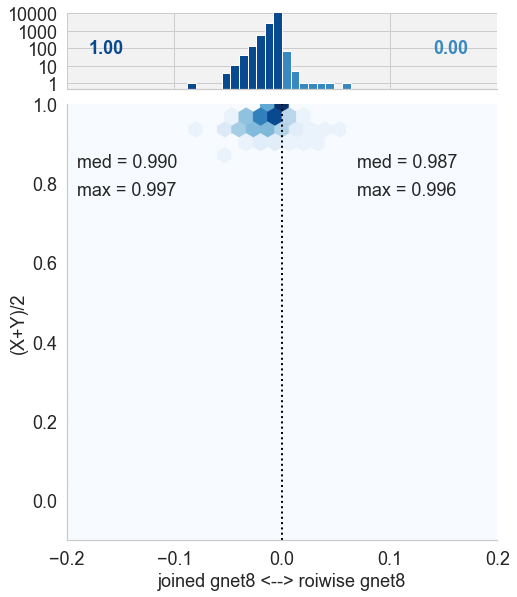

In [48]:
from src.plots import plot_fwrf_paper_compare

x = np.concatenate([v for s,v in gnetfj_val_cc.items()])
y = np.concatenate([v for s,v in gnetfr_val_cc.items()])

fig2b=plt.figure(figsize=(8, 8))
fig2b=plot_fwrf_paper_compare(x, y, 0.055, [-.2, .2], [-.1, 1.])
ax=fig2b.ax_joint
ax.text(x=-.2+.01, y=.84, s='med = %.3f'%np.median(np.nan_to_num(y)), fontsize=18)
ax.text(x=-.2+.01, y=.77, s='max = %.3f'%np.max(np.nan_to_num(y)), fontsize=18)
ax.text(x=.2 - .13, y=.84, s='med = %.3f'%np.median(np.nan_to_num(x)), fontsize=18)
ax.text(x=.2 - .13, y=.77, s='max = %.3f'%np.max(np.nan_to_num(x)), fontsize=18)
plt.xlabel('joined gnet8 <--> roiwise gnet8')

In [49]:
filename = output_dir + 'model_advantage_gnet8j_v_gnet8r_fake_%s%s'  % (noise_model, saveext)
fig2b.savefig(filename, **savearg)
plt.close()

# Cross-ROI model 

In [50]:
batch_size = 100
num_epochs = 50
holdout_frac = .1

for roi_name, roi_file_dir in roi_timestamp_dir.items(): 

    # create subdir
    model_dir     = roi_file_dir
    output_subdir = output_dir + roi_name + '/'
    print (output_subdir)
    if not os.path.exists(output_subdir):
        os.makedirs(output_subdir)

    print ('***************************************')
    print ('***        %12s       ***'%roi_name)
    print ('from ==> %s'%model_dir)
    print ('to   ==> %s'%output_subdir)
    print ('***************************************') 
    
    
    checkpoint = torch.load(model_dir)
    shared_params = checkpoint['best_params']
    ###
    
    shared_model = Encoder(trn_stim_mean, trunk_width=N).to(device)
    shared_model.load_state_dict(shared_params['enc'])
    shared_model.eval()     

    rec, fmaps, h = shared_model(T.from_numpy(stim_data[list(stim_data.keys())[0]][:20]).to(device))
    
    subject_fwrfs = {s: Torch_LayerwiseFWRF(fmaps, nv=trn_voxel_data[s].shape[1], pre_nl=_log_act_fn, \
                     post_nl=_log_act_fn, dtype=np.float32).to(device) for s in subjects}    
    
    subject_optimizer = {s: optim.Adam([
            {'params': sp.parameters()}
        ], lr=1e-3, betas=(0.9, 0.999), eps=1e-08) for s,sp in subject_fwrfs.items()}
    subject_opts = {s: [subject_optimizer[s]] for s in subject_optimizer.keys()}   
    ###################################
    

    best_params, final_params, hold_cc_hist, hold_hist, trn_hist, best_epoch, best_joint_cc_score = \
        learn_params_(_training_fn, _holdout_fn, _pred_fn, shared_model, subject_fwrfs, subject_opts, 
            stim_data, trn_voxel_data, trn_stim_ordering,
            num_epochs=num_epochs, batch_size=batch_size, holdout_frac=holdout_frac, randomize=False)
    
    
    ###################################
    #val_voxel = {s: val_voxel_data[s] for s in val_voxel_data.keys()}
    shared_model.load_state_dict(best_params['enc'])
    shared_model.eval() 
    for s,sd in subject_fwrfs.items():
        sd.load_state_dict(best_params['fwrfs'][s])
        sd.eval() 

    subject_val_cc = validation_(_pred_fn, shared_model, subject_fwrfs, stim_data, val_voxel_data, val_stim_ordering, batch_size)
    joined_val_cc = np.concatenate(list(subject_val_cc.values()), axis=0)
    
    print ('***************************************')
    print ("best joint val cc = %.3f"% np.median(joined_val_cc))
    for s,v in subject_val_cc.items():
        print ("subject %s: val cc = %.3f"%(s, np.median(v)))
 
    print ('***************************************')
    ###################################
    torch.save({
            'group_name': roi_name,
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'holdout_frac': holdout_frac,   
            'best_params': best_params, 
            'final_params': final_params,
            'trn_loss_history': trn_hist,
            'hold_loss_history': hold_hist,
            'hold_cc_history': hold_cc_hist,
            'best_epoch': best_epoch,
            'best_joint_cc_score': best_joint_cc_score,
            'val_cc': subject_val_cc,
            'input_mean': trn_stim_mean,
            'voxel_roi': voxel_roi
            }, output_subdir+'model_params_%s'%noise_model)

/export/raid1/home/styvesg/code/nsd_gnet8x/output/multisubject/gnet8r_pred_Feb-07-2022_1721/V1/
***************************************
***                  V1       ***
from ==> /export/raid1/home/styvesg/code/nsd_gnet8x/output/multisubject/gnet8r_pred_Feb-07-2022_1721//model_params_V1_no_noise
to   ==> /export/raid1/home/styvesg/code/nsd_gnet8x/output/multisubject/gnet8r_pred_Feb-07-2022_1721/V1/
***************************************
subject 1 masked 4627 of 4627
subject 1 training/holdout 8100 900
subject 2 masked 3765 of 3765
subject 2 training/holdout 8100 900
subject 3 masked 3778 of 3778
subject 3 training/holdout 8100 900
subject 4 masked 3027 of 3027
subject 4 training/holdout 8100 900
subject 5 masked 3685 of 3685
subject 5 training/holdout 8100 900
subject 6 masked 4024 of 4024
subject 6 training/holdout 8100 900
subject 7 masked 3201 of 3201
subject 7 training/holdout 8100 900
subject 8 masked 3490 of 3490
subject 8 training/holdout 8100 900
\ : 100.0 %
  Epoch 1 of 50 to

  Subject 8: median (max) validation accuracy = 0.954 (0.993)
** Saving params with joint score = 0.940 **

\ : 100.0 %
  Epoch 12 of 50 took       41.046s
  training loss:               0.149475
  holdout loss (batch):        0.121714
  Subject 1: median (max) validation accuracy = 0.922 (0.988)
  Subject 2: median (max) validation accuracy = 0.925 (0.990)
  Subject 3: median (max) validation accuracy = 0.950 (0.990)
  Subject 4: median (max) validation accuracy = 0.954 (0.993)
  Subject 5: median (max) validation accuracy = 0.963 (0.993)
  Subject 6: median (max) validation accuracy = 0.947 (0.993)
  Subject 7: median (max) validation accuracy = 0.952 (0.990)
  Subject 8: median (max) validation accuracy = 0.958 (0.993)
** Saving params with joint score = 0.946 **

\ : 100.0 %
  Epoch 13 of 50 took       40.957s
  training loss:               0.139743
  holdout loss (batch):        0.111357
  Subject 1: median (max) validation accuracy = 0.930 (0.988)
  Subject 2: median (max) valida

  Subject 1: median (max) validation accuracy = 0.965 (0.994)
  Subject 2: median (max) validation accuracy = 0.964 (0.995)
  Subject 3: median (max) validation accuracy = 0.974 (0.995)
  Subject 4: median (max) validation accuracy = 0.974 (0.996)
  Subject 5: median (max) validation accuracy = 0.974 (0.996)
  Subject 6: median (max) validation accuracy = 0.972 (0.996)
  Subject 7: median (max) validation accuracy = 0.975 (0.995)
  Subject 8: median (max) validation accuracy = 0.974 (0.996)
** Saving params with joint score = 0.971 **

\ : 100.0 %
  Epoch 25 of 50 took       40.790s
  training loss:               0.096190
  holdout loss (batch):        0.073839
  Subject 1: median (max) validation accuracy = 0.966 (0.994)
  Subject 2: median (max) validation accuracy = 0.965 (0.995)
  Subject 3: median (max) validation accuracy = 0.974 (0.995)
  Subject 4: median (max) validation accuracy = 0.974 (0.996)
  Subject 5: median (max) validation accuracy = 0.974 (0.996)
  Subject 6: median 

  Subject 5: median (max) validation accuracy = 0.976 (0.996)
  Subject 6: median (max) validation accuracy = 0.975 (0.997)
  Subject 7: median (max) validation accuracy = 0.977 (0.996)
  Subject 8: median (max) validation accuracy = 0.976 (0.996)
** Saving params with joint score = 0.975 **

\ : 100.0 %
  Epoch 37 of 50 took       40.859s
  training loss:               0.089579
  holdout loss (batch):        0.066125
  Subject 1: median (max) validation accuracy = 0.972 (0.996)
  Subject 2: median (max) validation accuracy = 0.970 (0.996)
  Subject 3: median (max) validation accuracy = 0.977 (0.996)
  Subject 4: median (max) validation accuracy = 0.977 (0.997)
  Subject 5: median (max) validation accuracy = 0.975 (0.996)
  Subject 6: median (max) validation accuracy = 0.975 (0.997)
  Subject 7: median (max) validation accuracy = 0.977 (0.996)
  Subject 8: median (max) validation accuracy = 0.977 (0.996)
** Saving params with joint score = 0.975 **

\ : 100.0 %
  Epoch 38 of 50 took   

  Subject 1: median (max) validation accuracy = 0.973 (0.996)
  Subject 2: median (max) validation accuracy = 0.971 (0.996)
  Subject 3: median (max) validation accuracy = 0.977 (0.996)
  Subject 4: median (max) validation accuracy = 0.977 (0.997)
  Subject 5: median (max) validation accuracy = 0.976 (0.996)
  Subject 6: median (max) validation accuracy = 0.975 (0.997)
  Subject 7: median (max) validation accuracy = 0.978 (0.996)
  Subject 8: median (max) validation accuracy = 0.977 (0.996)

\ : 100.0 %
  Epoch 50 of 50 took       40.812s
  training loss:               0.087078
  holdout loss (batch):        0.063090
  Subject 1: median (max) validation accuracy = 0.974 (0.996)
  Subject 2: median (max) validation accuracy = 0.972 (0.996)
  Subject 3: median (max) validation accuracy = 0.978 (0.996)
  Subject 4: median (max) validation accuracy = 0.978 (0.997)
  Subject 5: median (max) validation accuracy = 0.976 (0.997)
  Subject 6: median (max) validation accuracy = 0.976 (0.997)
  S

  Subject 6: median (max) validation accuracy = 0.939 (0.986)
  Subject 7: median (max) validation accuracy = 0.935 (0.983)
  Subject 8: median (max) validation accuracy = 0.949 (0.986)
** Saving params with joint score = 0.936 **

\ : 100.0 %
  Epoch 10 of 50 took       40.794s
  training loss:               0.166171
  holdout loss (batch):        0.133213
  Subject 1: median (max) validation accuracy = 0.907 (0.984)
  Subject 2: median (max) validation accuracy = 0.919 (0.989)
  Subject 3: median (max) validation accuracy = 0.942 (0.986)
  Subject 4: median (max) validation accuracy = 0.951 (0.987)
  Subject 5: median (max) validation accuracy = 0.965 (0.991)
  Subject 6: median (max) validation accuracy = 0.945 (0.987)
  Subject 7: median (max) validation accuracy = 0.943 (0.984)
  Subject 8: median (max) validation accuracy = 0.955 (0.987)
** Saving params with joint score = 0.943 **

\ : 100.0 %
  Epoch 11 of 50 took       40.818s
  training loss:               0.150117
  holdout 

\ : 100.0 %
  Epoch 22 of 50 took       40.808s
  training loss:               0.086319
  holdout loss (batch):        0.059515
  Subject 1: median (max) validation accuracy = 0.973 (0.994)
  Subject 2: median (max) validation accuracy = 0.973 (0.994)
  Subject 3: median (max) validation accuracy = 0.981 (0.994)
  Subject 4: median (max) validation accuracy = 0.981 (0.994)
  Subject 5: median (max) validation accuracy = 0.979 (0.995)
  Subject 6: median (max) validation accuracy = 0.979 (0.995)
  Subject 7: median (max) validation accuracy = 0.980 (0.994)
  Subject 8: median (max) validation accuracy = 0.981 (0.995)
** Saving params with joint score = 0.978 **

\ : 100.0 %
  Epoch 23 of 50 took       40.844s
  training loss:               0.084800
  holdout loss (batch):        0.056548
  Subject 1: median (max) validation accuracy = 0.974 (0.994)
  Subject 2: median (max) validation accuracy = 0.974 (0.994)
  Subject 3: median (max) validation accuracy = 0.982 (0.994)
  Subject 4: med

  Subject 2: median (max) validation accuracy = 0.979 (0.994)
  Subject 3: median (max) validation accuracy = 0.984 (0.995)
  Subject 4: median (max) validation accuracy = 0.984 (0.995)
  Subject 5: median (max) validation accuracy = 0.981 (0.995)
  Subject 6: median (max) validation accuracy = 0.982 (0.995)
  Subject 7: median (max) validation accuracy = 0.983 (0.995)
  Subject 8: median (max) validation accuracy = 0.983 (0.995)
** Saving params with joint score = 0.982 **

\ : 100.0 %
  Epoch 35 of 50 took       40.855s
  training loss:               0.077779
  holdout loss (batch):        0.051114
  Subject 1: median (max) validation accuracy = 0.979 (0.995)
  Subject 2: median (max) validation accuracy = 0.979 (0.994)
  Subject 3: median (max) validation accuracy = 0.984 (0.995)
  Subject 4: median (max) validation accuracy = 0.984 (0.995)
  Subject 5: median (max) validation accuracy = 0.981 (0.995)
  Subject 6: median (max) validation accuracy = 0.982 (0.995)
  Subject 7: median 

\ : 100.0 %
  Epoch 47 of 50 took       41.229s
  training loss:               0.075342
  holdout loss (batch):        0.051172
  Subject 1: median (max) validation accuracy = 0.981 (0.995)
  Subject 2: median (max) validation accuracy = 0.981 (0.994)
  Subject 3: median (max) validation accuracy = 0.984 (0.995)
  Subject 4: median (max) validation accuracy = 0.985 (0.995)
  Subject 5: median (max) validation accuracy = 0.982 (0.995)
  Subject 6: median (max) validation accuracy = 0.983 (0.996)
  Subject 7: median (max) validation accuracy = 0.984 (0.995)
  Subject 8: median (max) validation accuracy = 0.984 (0.995)

\ : 100.0 %
  Epoch 48 of 50 took       40.952s
  training loss:               0.074873
  holdout loss (batch):        0.048565
  Subject 1: median (max) validation accuracy = 0.981 (0.996)
  Subject 2: median (max) validation accuracy = 0.981 (0.994)
  Subject 3: median (max) validation accuracy = 0.985 (0.995)
  Subject 4: median (max) validation accuracy = 0.985 (0.995)

  Subject 4: median (max) validation accuracy = 0.925 (0.982)
  Subject 5: median (max) validation accuracy = 0.949 (0.986)
  Subject 6: median (max) validation accuracy = 0.923 (0.985)
  Subject 7: median (max) validation accuracy = 0.910 (0.977)
  Subject 8: median (max) validation accuracy = 0.931 (0.987)
** Saving params with joint score = 0.916 **

\ : 100.0 %
  Epoch 8 of 50 took       41.243s
  training loss:               0.208564
  holdout loss (batch):        0.173544
  Subject 1: median (max) validation accuracy = 0.866 (0.985)
  Subject 2: median (max) validation accuracy = 0.887 (0.985)
  Subject 3: median (max) validation accuracy = 0.920 (0.982)
  Subject 4: median (max) validation accuracy = 0.934 (0.984)
  Subject 5: median (max) validation accuracy = 0.954 (0.988)
  Subject 6: median (max) validation accuracy = 0.931 (0.987)
  Subject 7: median (max) validation accuracy = 0.920 (0.979)
  Subject 8: median (max) validation accuracy = 0.938 (0.989)
** Saving params with

  Subject 7: median (max) validation accuracy = 0.975 (0.990)
  Subject 8: median (max) validation accuracy = 0.977 (0.994)
** Saving params with joint score = 0.974 **

\ : 100.0 %
  Epoch 20 of 50 took       40.926s
  training loss:               0.091470
  holdout loss (batch):        0.064162
  Subject 1: median (max) validation accuracy = 0.966 (0.993)
  Subject 2: median (max) validation accuracy = 0.970 (0.991)
  Subject 3: median (max) validation accuracy = 0.977 (0.993)
  Subject 4: median (max) validation accuracy = 0.978 (0.992)
  Subject 5: median (max) validation accuracy = 0.977 (0.994)
  Subject 6: median (max) validation accuracy = 0.977 (0.995)
  Subject 7: median (max) validation accuracy = 0.976 (0.991)
  Subject 8: median (max) validation accuracy = 0.978 (0.994)
** Saving params with joint score = 0.975 **

\ : 100.0 %
  Epoch 21 of 50 took       40.917s
  training loss:               0.089335
  holdout loss (batch):        0.061448
  Subject 1: median (max) valida

\ : 100.0 %
  Epoch 32 of 50 took       40.966s
  training loss:               0.079236
  holdout loss (batch):        0.052198
  Subject 1: median (max) validation accuracy = 0.977 (0.994)
  Subject 2: median (max) validation accuracy = 0.978 (0.993)
  Subject 3: median (max) validation accuracy = 0.982 (0.994)
  Subject 4: median (max) validation accuracy = 0.982 (0.994)
  Subject 5: median (max) validation accuracy = 0.979 (0.995)
  Subject 6: median (max) validation accuracy = 0.982 (0.996)
  Subject 7: median (max) validation accuracy = 0.981 (0.994)
  Subject 8: median (max) validation accuracy = 0.981 (0.995)
** Saving params with joint score = 0.980 **

\ : 100.0 %
  Epoch 33 of 50 took       41.053s
  training loss:               0.078912
  holdout loss (batch):        0.051554
  Subject 1: median (max) validation accuracy = 0.977 (0.994)
  Subject 2: median (max) validation accuracy = 0.978 (0.993)
  Subject 3: median (max) validation accuracy = 0.982 (0.994)
  Subject 4: med

  Subject 4: median (max) validation accuracy = 0.983 (0.994)
  Subject 5: median (max) validation accuracy = 0.980 (0.995)
  Subject 6: median (max) validation accuracy = 0.983 (0.996)
  Subject 7: median (max) validation accuracy = 0.981 (0.994)
  Subject 8: median (max) validation accuracy = 0.982 (0.995)
** Saving params with joint score = 0.981 **

\ : 100.0 %
  Epoch 45 of 50 took       41.086s
  training loss:               0.075907
  holdout loss (batch):        0.051934
  Subject 1: median (max) validation accuracy = 0.979 (0.994)
  Subject 2: median (max) validation accuracy = 0.980 (0.993)
  Subject 3: median (max) validation accuracy = 0.983 (0.994)
  Subject 4: median (max) validation accuracy = 0.983 (0.993)
  Subject 5: median (max) validation accuracy = 0.980 (0.995)
  Subject 6: median (max) validation accuracy = 0.983 (0.996)
  Subject 7: median (max) validation accuracy = 0.981 (0.994)
  Subject 8: median (max) validation accuracy = 0.982 (0.995)

\ : 100.0 %
  Epoch

\ : 100.0 %
  Epoch 5 of 50 took       41.377s
  training loss:               0.312070
  holdout loss (batch):        0.274401
  Subject 1: median (max) validation accuracy = 0.771 (0.978)
  Subject 2: median (max) validation accuracy = 0.797 (0.979)
  Subject 3: median (max) validation accuracy = 0.859 (0.978)
  Subject 4: median (max) validation accuracy = 0.883 (0.980)
  Subject 5: median (max) validation accuracy = 0.921 (0.983)
  Subject 6: median (max) validation accuracy = 0.877 (0.980)
  Subject 7: median (max) validation accuracy = 0.852 (0.964)
  Subject 8: median (max) validation accuracy = 0.888 (0.987)
** Saving params with joint score = 0.868 **

\ : 100.0 %
  Epoch 6 of 50 took       41.374s
  training loss:               0.287859
  holdout loss (batch):        0.254111
  Subject 1: median (max) validation accuracy = 0.792 (0.980)
  Subject 2: median (max) validation accuracy = 0.815 (0.980)
  Subject 3: median (max) validation accuracy = 0.872 (0.979)
  Subject 4: media

  Subject 2: median (max) validation accuracy = 0.947 (0.988)
  Subject 3: median (max) validation accuracy = 0.961 (0.990)
  Subject 4: median (max) validation accuracy = 0.965 (0.991)
  Subject 5: median (max) validation accuracy = 0.966 (0.991)
  Subject 6: median (max) validation accuracy = 0.960 (0.993)
  Subject 7: median (max) validation accuracy = 0.957 (0.987)
  Subject 8: median (max) validation accuracy = 0.963 (0.993)
** Saving params with joint score = 0.959 **

\ : 100.0 %
  Epoch 18 of 50 took       41.181s
  training loss:               0.122278
  holdout loss (batch):        0.093720
  Subject 1: median (max) validation accuracy = 0.946 (0.991)
  Subject 2: median (max) validation accuracy = 0.950 (0.988)
  Subject 3: median (max) validation accuracy = 0.963 (0.991)
  Subject 4: median (max) validation accuracy = 0.967 (0.992)
  Subject 5: median (max) validation accuracy = 0.967 (0.991)
  Subject 6: median (max) validation accuracy = 0.962 (0.993)
  Subject 7: median 

  Subject 5: median (max) validation accuracy = 0.971 (0.993)
  Subject 6: median (max) validation accuracy = 0.972 (0.994)
  Subject 7: median (max) validation accuracy = 0.970 (0.991)
  Subject 8: median (max) validation accuracy = 0.973 (0.994)
** Saving params with joint score = 0.971 **

\ : 100.0 %
  Epoch 30 of 50 took       40.814s
  training loss:               0.098691
  holdout loss (batch):        0.070693
  Subject 1: median (max) validation accuracy = 0.965 (0.992)
  Subject 2: median (max) validation accuracy = 0.967 (0.991)
  Subject 3: median (max) validation accuracy = 0.974 (0.992)
  Subject 4: median (max) validation accuracy = 0.975 (0.994)
  Subject 5: median (max) validation accuracy = 0.971 (0.993)
  Subject 6: median (max) validation accuracy = 0.972 (0.994)
  Subject 7: median (max) validation accuracy = 0.970 (0.990)
  Subject 8: median (max) validation accuracy = 0.973 (0.994)
** Saving params with joint score = 0.971 **

\ : 100.0 %
  Epoch 31 of 50 took   

\ : 100.0 %
  Epoch 42 of 50 took       41.146s
  training loss:               0.093381
  holdout loss (batch):        0.066977
  Subject 1: median (max) validation accuracy = 0.969 (0.993)
  Subject 2: median (max) validation accuracy = 0.970 (0.992)
  Subject 3: median (max) validation accuracy = 0.975 (0.992)
  Subject 4: median (max) validation accuracy = 0.976 (0.994)
  Subject 5: median (max) validation accuracy = 0.973 (0.993)
  Subject 6: median (max) validation accuracy = 0.974 (0.994)
  Subject 7: median (max) validation accuracy = 0.972 (0.991)
  Subject 8: median (max) validation accuracy = 0.975 (0.994)
** Saving params with joint score = 0.973 **

\ : 100.0 %
  Epoch 43 of 50 took       41.104s
  training loss:               0.093162
  holdout loss (batch):        0.066273
  Subject 1: median (max) validation accuracy = 0.969 (0.993)
  Subject 2: median (max) validation accuracy = 0.970 (0.992)
  Subject 3: median (max) validation accuracy = 0.975 (0.992)
  Subject 4: med


# Cross model table

In [51]:
group_names = ['V1', 'V2', 'V3', 'hV4']
group = [[1,2], [3,4], [5,6], [7]]

crossroi_val_ccs = {}
for roi_name in ['V1', 'V2', 'V3', 'hV4']:
    checkpoint = torch.load('%s%s/model_params_%s'%(output_dir, roi_name, noise_model) )
    crossroi_val_ccs[roi_name] = checkpoint['val_cc']

In [52]:
subj_val_mat = {s: np.zeros(shape=(len(group_names), len(group_names))) for s in voxel_roi.keys()}
all_mat = np.zeros(shape=(len(group_names), len(group_names)))
all_count = np.zeros(shape=(len(group_names), len(group_names)))
for i,(i_roi_name, val_cc) in enumerate(crossroi_val_ccs.items()):
    print ('%d - %s'%(i, i_roi_name))
    for s, v in val_cc.items():
        for j, (roi_mask, j_roi_name) in enumerate(iterate_roi(group, voxel_roi[s], roi_map)):
            #print ('  %d - %s'%(j, j_roi_name))
            subj_val_mat[s][i,j] = np.mean(v[roi_mask] -  gnetfr_val_cc[s][roi_mask])
            all_mat[i,j] += np.sum(v[roi_mask] -  gnetfr_val_cc[s][roi_mask])
            all_count[i,j] += np.sum(roi_mask)

0 - V1
1 - V2
2 - V3
3 - hV4


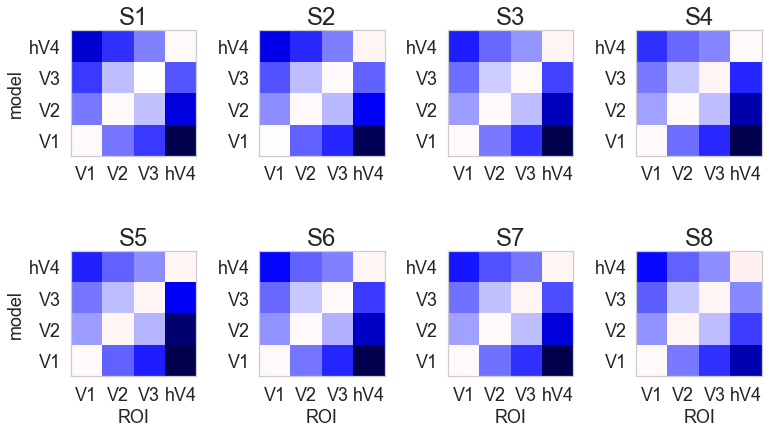

In [54]:
# line = model
# column = roi

fig=plt.figure(figsize=(12,6))
plt.subplots_adjust(left=0.15, bottom=0.1, right=.95, top=.95, wspace=.5, hspace=.5)

for k,(s,mat) in enumerate(subj_val_mat.items()):
    plt.subplot(2,4,k+1)
    plt.imshow(mat, cmap='seismic', vmin=-.05, vmax=.05, origin='lower')
    plt.grid(False)
    ax = plt.gca()
    ax.set_xticks(np.arange(len(group_names)))
    ax.set_xticklabels(group_names)
    ax.set_yticks(np.arange(len(group_names)))
    ax.set_yticklabels(group_names)
    if k%4==0:
        plt.ylabel('model')
    if k>=4:
        plt.xlabel('ROI')
    plt.title('S%s'%s)
    #if (k+1)%4==0:
    #    plt.colorbar()

In [55]:
filename = output_dir + "remodel_table_fake_%s%s" % (noise_model, saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

Text(0.5, 0, 'ROI')

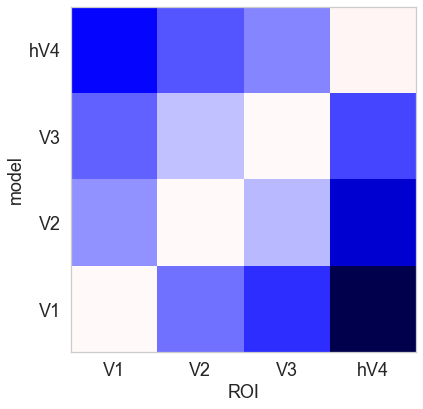

In [56]:
fig=plt.figure(figsize=(6,6))
plt.subplots_adjust(left=0.15, bottom=0.1, right=.95, top=.95, wspace=.5, hspace=.5)

plt.imshow(all_mat/all_count, cmap='seismic', vmin=-.05, vmax=.05, origin='lower')
plt.grid(False)
ax = plt.gca()
ax.set_xticks(np.arange(len(group_names)))
ax.set_xticklabels(group_names)
ax.set_yticks(np.arange(len(group_names)))
ax.set_yticklabels(group_names)
plt.ylabel('model')
plt.xlabel('ROI')

In [57]:
filename = output_dir + 'gnet8r_xmodel_table_fake_all_%s%s'  % (noise_model, saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

In [58]:
D_mat = np.array([[0,1,2,3], [1,0,1,2], [2,1,0,1],  [3,2,1,0]])
D_up_tri_mat = np.array([[0,0,0,0], [1,0,0,0], [2,1,0,0], [3,2,1,0]])
D_dn_tri_mat = np.array([[0,1,2,3], [0,0,1,2], [0,0,0,1], [0,0,0,0]])

from scipy.optimize import curve_fit
def fit_fn(x, a):
    return a*x

alpha, dalpha = {}, {}
for s,m in subj_val_mat.items():

    popt, pcov = curve_fit(fit_fn, D_up_tri_mat.flatten()[D_up_tri_mat.flatten()>0], m.flatten()[D_up_tri_mat.flatten()>0])
    perr = np.sqrt(np.diag(pcov))
    a_up, da_up = popt[0], perr[0]

    popt, pcov = curve_fit(fit_fn, D_dn_tri_mat.flatten()[D_dn_tri_mat.flatten()>0], m.flatten()[D_dn_tri_mat.flatten()>0])
    perr = np.sqrt(np.diag(pcov))
    a_dn, da_dn = popt[0], perr[0]
    
    alpha[s]  = (a_up - a_dn) / ( np.abs(a_up) + np.abs(a_dn) )
    dalpha[s] = np.abs(alpha[s]) * np.sqrt( (da_up**2 + da_dn**2) / (a_up - a_dn)**2 + (da_up**2 + da_dn**2) / (np.abs(a_up) + np.abs(a_dn))**2  )
    print (s, ':', alpha[s], '+/-', dalpha[s])

1 : 0.15940161050338802 +/- 0.06399297448596034
2 : 0.18718579351377174 +/- 0.05880494487246381
3 : 0.3588682399970319 +/- 0.08477148951696847
4 : 0.4005326727838038 +/- 0.09217241803150215
5 : 0.4641417134759827 +/- 0.11357713771548505
6 : 0.3232343438072127 +/- 0.0750464288772547
7 : 0.3083494005914741 +/- 0.07912644502187012
8 : 0.1477069582487938 +/- 0.046071053660319716


In [59]:
for s,m in {'all': all_mat/all_count}.items():

    popt, pcov = curve_fit(fit_fn, D_up_tri_mat.flatten()[D_up_tri_mat.flatten()>0], m.flatten()[D_up_tri_mat.flatten()>0])
    perr = np.sqrt(np.diag(pcov))
    a_up, da_up = popt[0], perr[0]

    popt, pcov = curve_fit(fit_fn, D_dn_tri_mat.flatten()[D_dn_tri_mat.flatten()>0], m.flatten()[D_dn_tri_mat.flatten()>0])
    perr = np.sqrt(np.diag(pcov))
    a_dn, da_dn = popt[0], perr[0]
    
    alpha[s]  = (a_up - a_dn) / ( np.abs(a_up) + np.abs(a_dn) )
    dalpha[s] = np.abs(alpha[s]) * np.sqrt( (da_up**2 + da_dn**2) / (a_up - a_dn)**2 + (da_up**2 + da_dn**2) / (np.abs(a_up) + np.abs(a_dn))**2  )
    print (s, ':', alpha[s], '+/-', dalpha[s])

all : 0.29716742842586547 +/- 0.07427850953640995


In [60]:
print (noise_model)

no_noise
